In [1]:
from cellpose import models, io
from cellpose.io import *
from collections import defaultdict
import geopandas
import glob
import imagej
from jpype import JArray, JInt
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import re
import pandas
from pandas import DataFrame
from pathlib import Path
import scyjava
import seaborn
import shutil
import tkinter as tk
from tkinter import filedialog
from PIL import Image
import sys
from zipfile import ZipFile
import csv
import random
from math import isnan 
from sklearn.cluster import AgglomerativeClustering
from PyQt5.QtWidgets import QApplication, QMainWindow, QWidget, QScrollArea, QLabel, QGridLayout
from PyQt5.QtGui import QPixmap
from PyQt5.QtCore import Qt
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import discriminant_analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

In [2]:
scyjava.config.add_option('-Xmx30g')
#ij = imagej.init('/home/saka/fiji-linux64/Fiji.app', mode = 'interactive')
ij = imagej.init('/home/saka/sw/local/fiji/2023', mode='interactive')
ij.ui().showUI()
ij.getVersion()

'2.14.0/1.54f'

In [3]:
# Different plugin needed for the workflow
showPolygonRoi = scyjava.jimport('ij.gui.PolygonRoi')
Overlay = scyjava.jimport('ij.gui.Overlay')
Regions = scyjava.jimport('net.imglib2.roi.Regions')
LabelRegions = scyjava.jimport('net.imglib2.roi.labeling.LabelRegions')
ZProjector = scyjava.jimport('ij.plugin.ZProjector')()
Duplicator = scyjava.jimport('ij.plugin.Duplicator')()
ov = Overlay()
Model =  scyjava.jimport('fiji.plugin.trackmate.Model')
Settings= scyjava.jimport('fiji.plugin.trackmate.Settings')
TrackMate = scyjava.jimport('fiji.plugin.trackmate.TrackMate')
Settings= scyjava.jimport('fiji.plugin.trackmate.Settings')
TrackMate = scyjava.jimport('fiji.plugin.trackmate.TrackMate')
Logger= scyjava.jimport('fiji.plugin.trackmate.Logger')
DetectorKeys= scyjava.jimport('fiji.plugin.trackmate.detection.DetectorKeys') 
ExportTracksToXML= scyjava.jimport('fiji.plugin.trackmate.action.ExportTracksToXML') 
TmXmlWriter= scyjava.jimport('fiji.plugin.trackmate.io.TmXmlWriter')
LogRecorder = scyjava.jimport('fiji.plugin.trackmate.util.LogRecorder')
SparseLAPTrackerFactory= scyjava.jimport('fiji.plugin.trackmate.tracking.jaqaman.SparseLAPTrackerFactory')
TMUtils = scyjava.jimport('fiji.plugin.trackmate.util.TMUtils')
HyperStackDisplayer = scyjava.jimport('fiji.plugin.trackmate.visualization.hyperstack.HyperStackDisplayer')
SelectionModel = scyjava.jimport('fiji.plugin.trackmate.SelectionModel')
CellposeDetectorFactory = scyjava.jimport('fiji.plugin.trackmate.cellpose.CellposeDetectorFactory')
FeatureFilter = scyjava.jimport('fiji.plugin.trackmate.features.FeatureFilter')
DisplaySetting = scyjava.jimport('fiji.plugin.trackmate.gui.displaysettings.DisplaySettings')
DisplaySettingsIO = scyjava.jimport('fiji.plugin.trackmate.gui.displaysettings.DisplaySettingsIO')
CaptureOverlayAction = scyjava.jimport('fiji.plugin.trackmate.action.CaptureOverlayAction')
PretrainedModel= scyjava.jimport('fiji.plugin.trackmate.cellpose.CellposeSettings.PretrainedModel')
ThresholdDetectorFactory= scyjava.jimport('fiji.plugin.trackmate.detection.ThresholdDetectorFactory')
TrackScheme = scyjava.jimport('fiji.plugin.trackmate.visualization.trackscheme.TrackScheme')
TrackTableView = scyjava.jimport('fiji.plugin.trackmate.visualization.table.TrackTableView')
AllSpotsTableView = scyjava.jimport('fiji.plugin.trackmate.visualization.table.AllSpotsTableView')

rm = ij.RoiManager.getRoiManager()

In [4]:
directory_path = f"/home/saka/Documents/Lab_stuff/confocal/20240229 hmdm claurdan h37dsred/inf"
image_path = f"{directory_path}/Experiment-2111-1.tif"

In [5]:
image = ij.io().open(image_path)

In [6]:
image_np = ij.py.from_java(ij.op().convert().float32(image))  # Ensures float32 dtype
dim_x, dim_y, n_channels = image_np.shape

In [7]:
alpha = np.zeros((dim_x, dim_y))

# Fractional Analysis: Compute intensity and alpha
intensity_total = np.sum(image_np, axis=2)
intensity_channel1 = image_np[:, :, 0]

# Avoid divide-by-zero errors using a threshold
threshold = 1e-6
mask = intensity_total > threshold
alpha[mask] = intensity_channel1[mask] / intensity_total[mask]

# Clamp alpha values between 0 and 1
alpha = np.clip(alpha, 0, 1)

In [8]:
# Normalize intensity for plotting
intensity_max = image_np.max(axis=(0, 1))  # Max for each channel
phasor_dim = 256  # Resolution of the phasor plot

# Compute normalized coordinates for the phasor plot
jx = (phasor_dim * image_np[:, :, 0] / intensity_max[0]).astype(int)
jy = (phasor_dim * (1 - image_np[:, :, 1] / intensity_max[1])).astype(int)

# Initialize the phasor histogram
phasor_hist = np.zeros((phasor_dim, phasor_dim))

# Populate the histogram
for i in range(dim_x):
    for j in range(dim_y):
        if intensity_total[i, j] > threshold:
            if 0 <= jx[i, j] < phasor_dim and 0 <= jy[i, j] < phasor_dim:
                phasor_hist[jx[i, j], jy[i, j]] += 1

# Normalize phasor histogram for color mapping
phasor_hist = phasor_hist / phasor_hist.max()

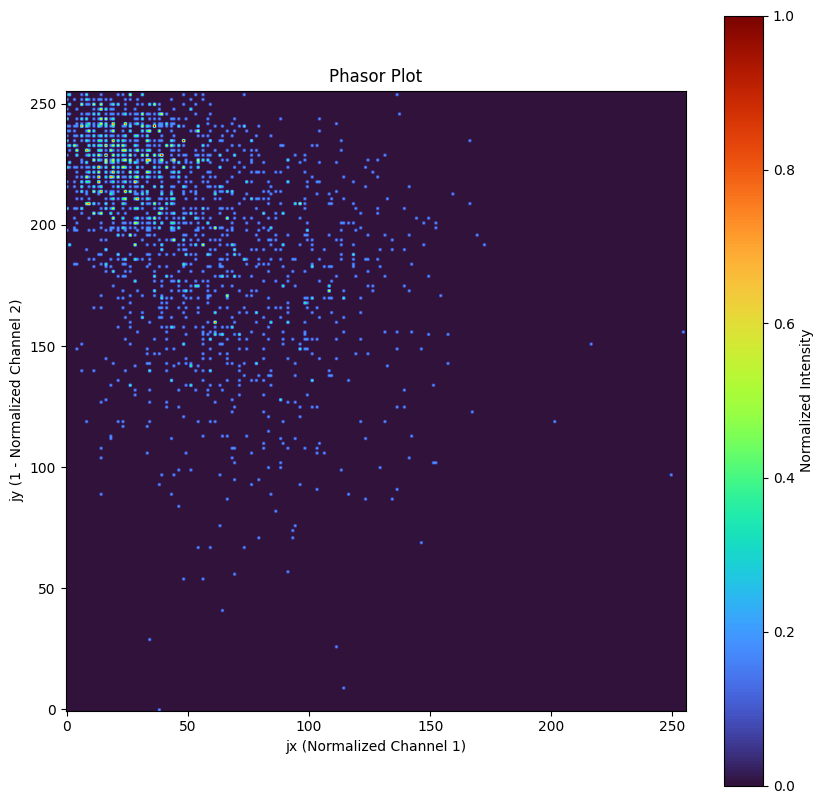

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(phasor_hist.T, cmap="turbo", origin="lower")
plt.colorbar(label="Normalized Intensity")
plt.title("Phasor Plot")
plt.xlabel("jx (Normalized Channel 1)")
plt.ylabel("jy (1 - Normalized Channel 2)")
plt.show()

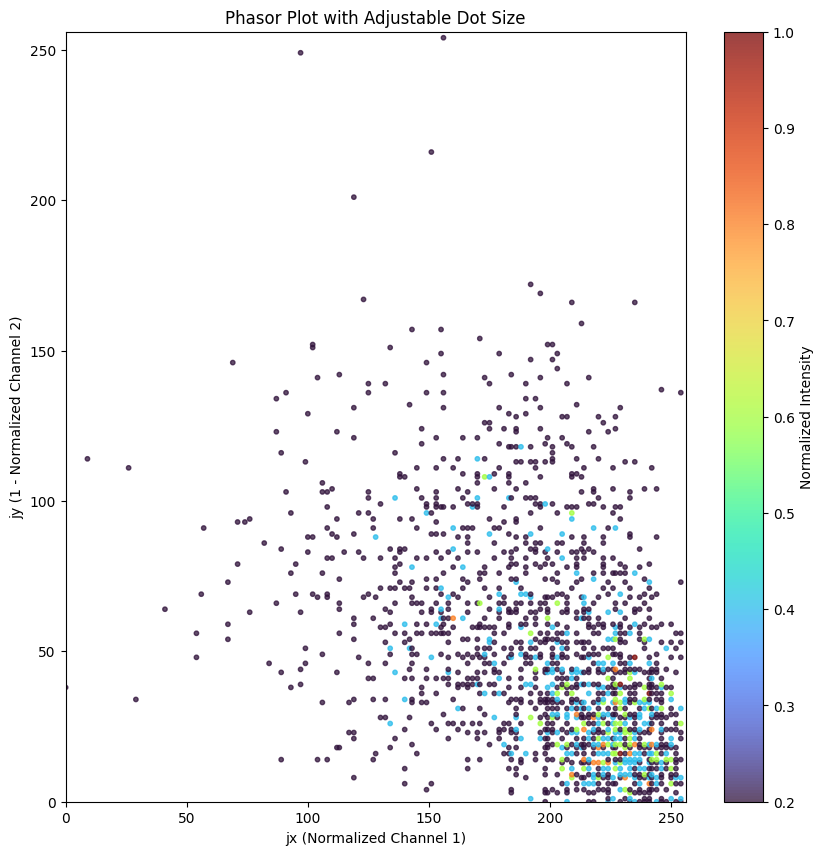

In [16]:
# Generate coordinates for the phasor plot based on the histogram
y, x = np.nonzero(phasor_hist)  # Get non-zero indices
intensity = phasor_hist[y, x]   # Get intensity values for these indices

# Create a scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(
    x, y, 
    c=intensity, 
    s=10,  # Scale the dot size; adjust as needed
    cmap="turbo", 
    alpha=0.75
)
plt.colorbar(label="Normalized Intensity")
plt.title("Phasor Plot with Adjustable Dot Size")
plt.xlabel("jx (Normalized Channel 1)")
plt.ylabel("jy (1 - Normalized Channel 2)")
plt.xlim(0, phasor_dim)
plt.ylim(0, phasor_dim)
plt.show()